# Lab 7 (a) - PCC177/BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Modelos Generativos

### Prof. Eduardo e Prof. Pedro

### Aluna: Daniela Costa Terra

Objetivos:

- Predição de série temporal com redes recorrentes (RNN)

Data da entrega : XX/YY

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-Lab6.pdf"
- Envie o PDF via google [FORM](https://forms.gle/gj36yASmF4Lmrrtx7)

Este notebook é baseado em tensorflow e Keras.

# Predição de preço de criptomoedas com redes recorrentes

Informação sobre o Bitcoin : https://www.kaggle.com/ibadia/bitcoin-101-bitcoins-and-detailed-insights


O valor de uma criptomoeda, assim como um ativo funanceiro do mercado de ações, pode ser configurado com uma série temporal. Aqui, consideraremos o valor ponderado do preço diário do Bitcoin para constuir nossa série. O objetivo deste estudo é predizer o próximo valor, baseado nos últimos valores da criptomoeda. Para tal, usaremos de redes recorrentes, pois as mesmas tem memória, o que é importante quando se trata de dados sequenciais.


## Carregando os pacotes

In [ ]:
# Importa as bibliotecas necessárias
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GRUCell
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Vamos usar o pacote ***quandl*** para baixar diretamente dados fornecidos por uma corretora de criptomoedas (Kraken).

In [ ]:
!pip install quandl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Carregando os dados

In [ ]:
# baixa os dados da exchange Kraken, até o período atual.
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas', authtoken='W7yLxrz_tTxB3sSVRQKB')


## Entendendo os dados

In [ ]:
#exibe as primeiras linahs 
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2713 entries, 2014-01-07 to 2021-06-20
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2713 non-null   float64
 1   High               2713 non-null   float64
 2   Low                2713 non-null   float64
 3   Close              2713 non-null   float64
 4   Volume (BTC)       2713 non-null   float64
 5   Volume (Currency)  2713 non-null   float64
 6   Weighted Price     2713 non-null   float64
dtypes: float64(7)
memory usage: 169.6 KB


In [ ]:
# verifica os últimos dados. Repare na data. Deve ter dados atuais (Jun / 2021).
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2021-06-16,40167.3,40493.0,38120.0,38337.1,6487.206888,2.539206e+08,39141.737747
2021-06-17,38337.1,39561.4,37405.0,38078.2,6003.220618,2.307246e+08,38433.468618
2021-06-18,38078.2,38193.1,35126.0,35824.0,6558.468890,2.409217e+08,36734.445103
2021-06-19,35824.0,36450.0,34901.0,35490.5,4485.076656,1.603145e+08,35743.971502
2021-06-20,35484.2,36112.2,33370.0,35668.7,6229.513564,2.168125e+08,34804.086189


Repare que temos dados de abertura do pregão, fechamento, valor mais alto, valor mais baixo, volume diário do bitcoin e de todas as criptomoedas combinadas. E também, temos os preço ponderado pelos valores de compra/venda de um período, que em nosso caso é diário. Para facilitar, vamos usar o valor ponderado.

## Plotando os dados

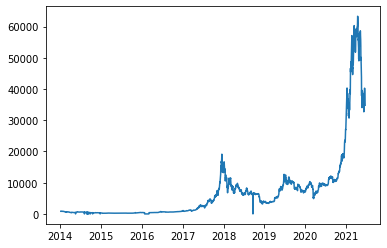

In [ ]:
# imprima os dados
pyplot.plot(data['Weighted Price'])

## Pré-processamento dos dados

In [ ]:
#existem alguns pontos com valor zero (outliers), vamos trocar por NaN e depois chamar um método para preencher os valores vazios
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

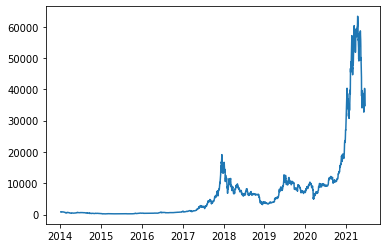

In [ ]:
# imprima novamente e observe que não existe mais estes outliers.
pyplot.plot(data['Weighted Price'])

In [173]:
# vamos usar o preço ponderado como entrada para nossa rede recorrente
# como já vimos, eh sempre bom normalizar os dados para ajudar na convergência do treinamento
# Normaliza na faixa entre [0 e 1]
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
print(values[0].dtype, np.amin(values), np.amax(values), values.shape)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled[0].dtype, np.amin(scaled), np.amax(scaled), np.mean(scaled), scaled.shape)

float64 199.628389448 63326.47055027381 (2713, 1)
float32 0.0 1.0 0.10820114 (2713, 1)


In [ ]:
# vamos deixar 70% para treino e 30% para teste. Observe que temos mais de 6 anos de dados.
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1899 814


Vamos considerar uma janela de um único dia para efetuar a predição. Para isso, use a função create_dataset(..) e deixe o parâmetro look_back=1. O parâmetro look_back controla a quantidade de dados que vai fazer parte da janela de entrada para a rede. Estude e entenda o que a função faz.

In [ ]:
#função para criar os conjuntos de dados de treino
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [ ]:
# entra com janela de 1 único valor
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1898
813


In [ ]:
trainX.shape, trainX.shape, trainY.shape 

((1898, 1, 1), (1898, 1, 1), (1898,))

In [ ]:
# reshape para formato de entrada da rede neural (instancias, 1, 1)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX.shape

(1898, 1, 1)

## Projeto de uma rede recorrente

Projete uma rede recorrente, usando alguma das camadas abaixo:

```
  tf.keras.layers.LSTM
  tf.keras.layers.GRU
  tf.keras.layers.RNN
```

As camadas recorrentes (LSTM, GRU, RNN) podem ser bidirecionais ou simpels, por exemplo, uma camada LSTM com 32 unidades e bidirecional:

 ```
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
 ```

Você também pode usar dropout e camadas densas em seu modelo. 

Experimente três arquiteturas (rasas e profundas) e pelo menos dois algoritmos de otimização. Documente os resultados em uma tabela e anexe.

 Por exemplo, você pode usar um modelo raso como o abaixo:

```
 np.random.seed(42)
 tf.random.set_seed(42)


 model_1 = Sequential([
   LSTM(128,input_shape=[None,1]),
   Dense(1)
 ])
```

Com uma função de custo **Mean Square Error** e o algoritmo de otimização **ADAM**:

```
 model_1.compile(loss='mse',optimizer = 'adam')
```

Ou pode usar um modelo profundo, mais complexo como o abaixo:

```
 model = Sequential()
 model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
 model.add(Dense(units = 64, activation='relu'))
 model.add(Dropout(dropout_rate))
 model.add(Dense(units = 1))
```

O **erro médio quadrático** deste último modelo, com o otimizador **ADAM** e **erro médio quadrático** como função de custo deve resultar em:

```
 Test Root Mean Square Error (RMSE): 380.139
```

### Observações
1. **Seu RMSE pode ser diferente devido aos dados usados.**
2. **Use modelos diferentes dos de exemplo!**


 

## ToDo: Projetando os seus modelos (30pt)

##### Funções Modelos

In [250]:
import matplotlib.pyplot as plt

# Exibe métricas de treino e validação ()
def plot_segm_history(history, epochs_ini, lossLimit = 1,
                      metrics=["mean_squared_error", "val_mean_squared_error"], losses=["loss", "val_loss"]):
    """
    Args:
        history: dicionário retornado de 'fit'
        metrics:  lista de métricas realizadas durante treino/validação
        losses: estatísticas de perda durante treino/validação 
    """
    epochs =  history.params['epochs']
    if metrics is not None:
      _, axis = plt.subplots(1, len(metrics), figsize=(10,5))
      for i, metric in enumerate(metrics):
          axis[i].plot(history.history[metric], label=metric)
          axis[i].set_title(metric + ' over epochs') 
          axis[i].set_xlim([epochs_ini, epochs])
          axis[i].set_ylim([0, tf.reduce_max(history.history[metric])*1.5])
          axis[i].legend()
 
    data = [] 
    # Gráfico history for loss:
    for loss in losses:
          data.append(history.history[loss])         
    plt.figure()
    plt.plot(list(range(epochs)), data[0], 'r', label='Training loss')
    plt.plot(list(range(epochs)), data[1], 'bo', label='Validation loss')
    plt.title("Loss over epochs")
    plt.ylabel("Loss Value")
    plt.xlabel("Epoch")
    plt.xlim([epochs_ini, epochs])
    plt.ylim([0, (tf.reduce_max(data[0])*1.5+ tf.reduce_max(data[1])*1.5)])
    plt.legend()
    plt.show()  

In [382]:

# ToDO : projete o modelo aqui
np.random.seed(42)
tf.random.set_seed(42)

def gruModel(num_hiddens, num_layers=2, dropout=0.5):
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)
    gru_cells = [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout,kernel_initializer=initializer)
                         for _ in range(num_layers)]
    rnn = tf.keras.layers.RNN(gru_cells, return_sequences=False)
    
    model = Sequential([
               tf.keras.layers.InputLayer(input_shape=[None, 1]),
               rnn, 
               Dense(num_hiddens*2, activation='relu'),         
               Dense(1)         
    ])
    return model

def lstmModel(num_hiddens, num_layers=2, dropout=0.5, bidiretional=False):
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
    lstm_cells = [tf.keras.layers.LSTMCell(num_hiddens, dropout=dropout,kernel_initializer=initializer)
                     for _ in range(num_layers)]
    if (bidiretional):
        rnn = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(lstm_cells, return_sequences=False))
    else:
        rnn = tf.keras.layers.RNN(lstm_cells, return_sequences=False)
    
    model = Sequential([
               tf.keras.layers.InputLayer(input_shape=[None, 1]),
               rnn, 
               Dense(num_hiddens*2, activation='relu'),         
               Dense(1)         
    ])
    return model


def dado(dropout_rate = 0):
   model = Sequential()
   model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
   model.add(Dense(units = 64, activation='relu'))
   model.add(tf.keras.layers.Dropout(dropout_rate))
   model.add(Dense(units = 1))
   return model


#### Modelo 1:  

1 célula LSTM(64 units), dropout(0.5), Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.799), Loss(MSE)

In [469]:
modelo_1 = lstmModel(64, num_layers=1, dropout=0.5)
 


#### Modelo 2:
DeepRNN de 3 células GRU(32 units) , dropout(0.5), optimizer = RMSprop(
learning_rate=0.0001, rho=0.7,  momentum=0.0
), Loss(MAE)

In [471]:
# ToDO : projete o modelo aqui
modelo_2 = gruModel(64, num_layers=3, dropout=0.5)


#### Modelo 3: 

Bidirecional DeepRNN de 2 células LSTM(32 units) , dropout(0.5), Adam(learning_rate=0.0001, beta_1=0.6, beta_2=0.799), Loss(MAE)

In [475]:

# ToDO : projete o modelo aqui
modelo_3 = lstmModel(32, num_layers=3, dropout=0.5, bidiretional=True)

 

## ToDo: Função de custo (10pt)

Como é um problema de regressão, usaremos funções de custo apropriadas. Você pode usar, por exemplo, *Mean Absolute Error* (mae) ou *Mean Squared Error* (mse). 

**ToDo:** Estude as funções de custo MAE e MSE. Qual das duas funções você usaria. Justifique sua escolha. Repare que vamos avaliar os modelos pela métrica *Root Mean Square Error* (RMSE).

A função de perda MAE (erro médio absoluto) para valores menores que 1, resulta em valores maiores para a função de perda, o que resulta numa taxa de correção de pesos maior, se aplicada a mesma taxa de aprendizagem. Ao contrário, a função MSE retorna valores de perdas menores. Sendo o ajuste dos pesos da rede dependente do valor do gradiente e da taxa de aprendizagem, se a função de perda retorna valores maiores (MAE), deve-se ajustar a taxa de aprendizagem para evitar erros de convergência na aprendizagem. Da mesma maneira, sendo a função de perda MSE, pode-se aplicar taxas de aprendizagem maiores compensando o ajuste dos pesos. No modelos acima foi aplicado MAE para verificar a convergência ajustando os parâmetros da taxa de aprendizagem.

## ToDo: Função para treinar o seu modelo (15pt)

In [453]:
# Função para treinar o modelo
def train_model(model, loss, optimizer, trainX, trainY, testX, testY):
  # Compile o modelo : atenção para a função de CUSTO. Abaixo um exemplo de uso da 'mae'
  model.compile(loss=loss, optimizer=optimizer,  metrics = tf.keras.metrics.MeanSquaredError(
                                name='mean_squared_error', dtype=None)
                )
 
  #treine o modelo
  history = model.fit( # todo...
    x=trainX,
    y=trainY,
    batch_size=100,
    epochs=150,
    validation_data=(testX, testY),
    shuffle=True,
    initial_epoch=0,
  )
  # plote a curva de custo
  plot_segm_history(history, 0, lossLimit=1, metrics=["mean_squared_error", 
                                                      "val_mean_squared_error"])

## Função para avaliar o seu modelo


In [462]:
# Avaliando o modelo treinado
def evaluate_model(model, testX, testY):

  # plote as curvas, valor real e valor predito no mesmo gráfico
  yhat = model.predict(testX)
  pyplot.title('Curva do valor real e valor predito na escala usado no treino')
  pyplot.plot(yhat, label='predict')
  pyplot.plot(testY, label='true')
  pyplot.legend()
  pyplot.show()
  
  # os valores foream normalizados para o treinamento. 
  # Veja que para fazer sentido, eles devem voltar para a escala original.
  # Volta para escala em US dollar :
  yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
  testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

  # calculo de métricas: MAE, MSE e RMSE 
  #rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
  mae = tf.keras.metrics.MeanAbsoluteError()
  mse = tf.keras.metrics.MeanSquaredError()
  rmse = tf.keras.metrics.RootMeanSquaredError()

  print(f'MAE: {mae(testY_inverse, yhat_inverse).numpy()},\nMSE: {mse(testY_inverse, yhat_inverse).numpy()},\nRMSE: {rmse(testY_inverse, yhat_inverse).numpy()}')
  #print('\nTest RMSE: %.3f\n' % rmse)

  # valor em US dollar
  pyplot.title('Curva do valor real e valor predito em US dollar')
  pyplot.plot(yhat_inverse, label='predict')
  pyplot.plot(testY_inverse, label='actual', alpha=0.5)
  pyplot.legend()
  pyplot.show()

## ToDo: Treinando e avaliando o seu modelo (15pt)

### Modelo 1

In [ ]:
# Modelo 1
modelo_1 = lstmModel(64, num_layers=1, dropout=0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.799,
)
 
loss= tf.keras.losses.MeanAbsoluteError(
    reduction=tf.keras.losses.Reduction.AUTO,
    name='MAE'
)


In [ ]:
train_model(modelo_1, loss, optimizer, trainX, trainY, testX, testY)

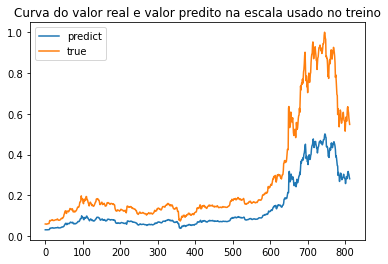

MAE: 8529.6025390625,
MSE: 136624016.0,
RMSE: 11688.6279296875


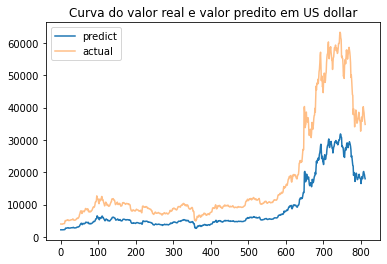

In [463]:
evaluate_model(modelo_1, testX, testY)

### Modelo 2

In [477]:
# Modelo 2
modelo_2 = gruModel(64, num_layers=3, dropout=0.5)

optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.0001, rho=0.9,
    momentum=0.0
)
 
loss= tf.keras.losses.MeanAbsoluteError(
    reduction=tf.keras.losses.Reduction.AUTO,
    name='MAE'
)

Epoch 1/150
19/19 [==============================] - 5s 31ms/step - loss: 0.0347 - mean_squared_error: 0.0039 - val_loss: 0.2561 - val_mean_squared_error: 0.1261
Epoch 2/150
19/19 [==============================] - 0s 9ms/step - loss: 0.0335 - mean_squared_error: 0.0036 - val_loss: 0.2501 - val_mean_squared_error: 0.1206
Epoch 3/150
19/19 [==============================] - 0s 11ms/step - loss: 0.0326 - mean_squared_error: 0.0034 - val_loss: 0.2467 - val_mean_squared_error: 0.1161
Epoch 4/150
19/19 [==============================] - 0s 9ms/step - loss: 0.0315 - mean_squared_error: 0.0032 - val_loss: 0.2357 - val_mean_squared_error: 0.1076
Epoch 5/150
19/19 [==============================] - 0s 9ms/step - loss: 0.0304 - mean_squared_error: 0.0031 - val_loss: 0.2263 - val_mean_squared_error: 0.0994
Epoch 6/150
19/19 [==============================] - 0s 9ms/step - loss: 0.0291 - mean_squared_error: 0.0028 - val_loss: 0.2138 - val_mean_squared_error: 0.0893
Epoch 7/150
19/19 [=============

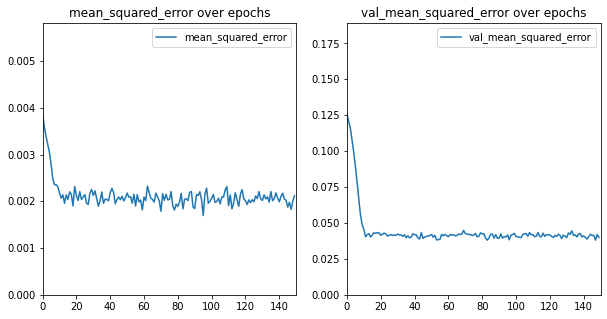

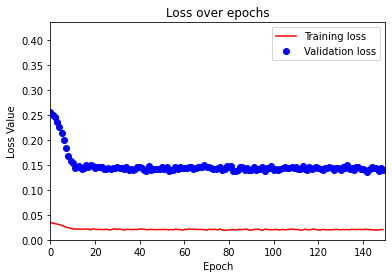

In [478]:
train_model(modelo_2, loss, optimizer, trainX, trainY, testX, testY)

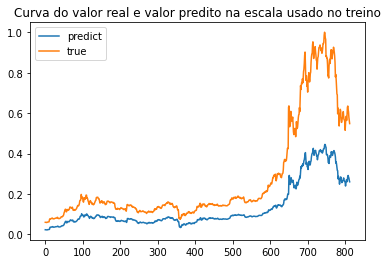

MAE: 8891.3828125,
MSE: 158967104.0,
RMSE: 12608.2158203125


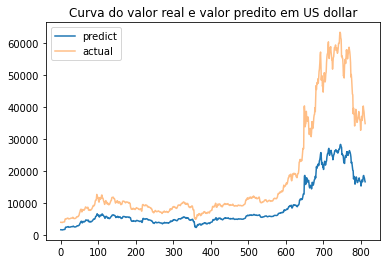

In [480]:
evaluate_model(modelo_2, testX, testY)

### Modelo 3

In [481]:
# Modelo 3
modelo_3 = lstmModel(32, num_layers=3, dropout=0.5, bidiretional=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.6, beta_2=0.799,
)
 
loss= tf.keras.losses.MeanAbsoluteError(
    reduction=tf.keras.losses.Reduction.AUTO,
    name='MAE'
)

Epoch 1/150
19/19 [==============================] - 8s 53ms/step - loss: 0.0355 - mean_squared_error: 0.0040 - val_loss: 0.2633 - val_mean_squared_error: 0.1325
Epoch 2/150
19/19 [==============================] - 0s 11ms/step - loss: 0.0350 - mean_squared_error: 0.0039 - val_loss: 0.2628 - val_mean_squared_error: 0.1322
Epoch 3/150
19/19 [==============================] - 0s 10ms/step - loss: 0.0350 - mean_squared_error: 0.0039 - val_loss: 0.2652 - val_mean_squared_error: 0.1335
Epoch 4/150
19/19 [==============================] - 0s 11ms/step - loss: 0.0351 - mean_squared_error: 0.0039 - val_loss: 0.2642 - val_mean_squared_error: 0.1330
Epoch 5/150
19/19 [==============================] - 0s 10ms/step - loss: 0.0350 - mean_squared_error: 0.0039 - val_loss: 0.2646 - val_mean_squared_error: 0.1332
Epoch 6/150
19/19 [==============================] - 0s 11ms/step - loss: 0.0351 - mean_squared_error: 0.0039 - val_loss: 0.2644 - val_mean_squared_error: 0.1331
Epoch 7/150
19/19 [=========

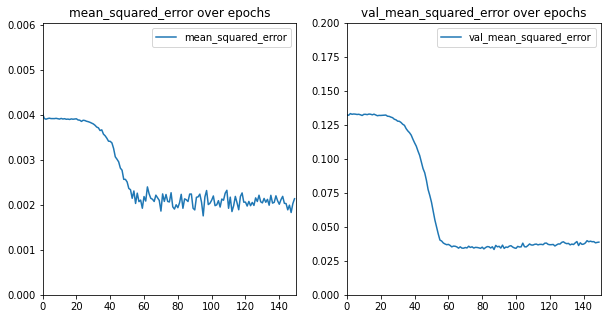

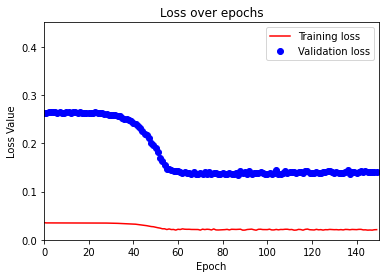

In [482]:
train_model(modelo_3, loss, optimizer, trainX, trainY, testX, testY)

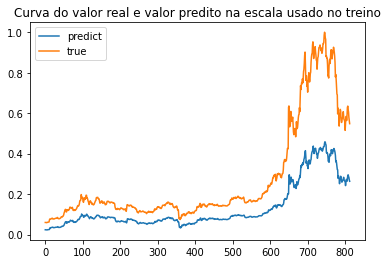

MAE: 8851.1220703125,
MSE: 154572000.0,
RMSE: 12432.69921875


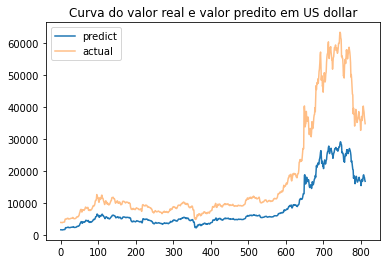

In [483]:
evaluate_model(modelo_3, testX, testY)

#### Comparação dos modelos:
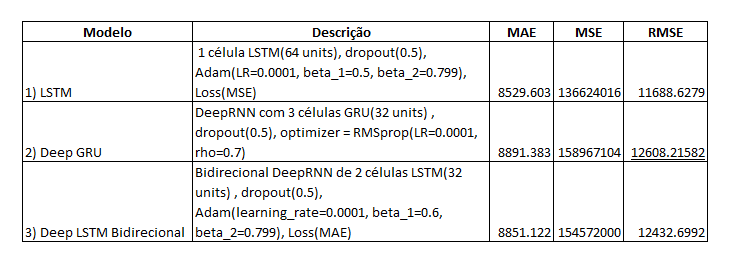

## Prevendo o próximo dia

In [489]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def baseline(history):
  return np.mean(history)
  
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  pyplot.title(title)
  for i, x in enumerate(plot_data):
    if i:
      pyplot.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      pyplot.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  pyplot.legend()
  pyplot.xlim([time_steps[0], (future+5)*2])
  pyplot.xlabel('Time-Step')
  return pyplot

### ToDo: Função para predizer o próximo dia (15pt)

In [491]:
def predict_next_day(model, testX, testY):
  # os valores foream normalizados para o treinamento. 
  # Veja que para fazer sentido, eles devem voltar para a escala original.
  # Volta para escala em US dollar :
  yhat_inverse = scaler.inverse_transform(model.predict(testX).reshape(-1, 1))
  testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

  # na base de teste, plote até a instância 200 e tente predizer a instância futura: 201
  # use a função show_plot
  show_plot([testY_inverse[0:200], testY_inverse[201],  
             #baseline(testY_inverse[201])], 1, 'Predição do dia seguinte')
             yhat_inverse[201]], 1, 'Predição do dia seguinte')
  
  print('valor predito do dia 201: ', yhat_inverse[201])
  print('Valor real do dia 201: ', testY_inverse[201])

#### Modelo 1:

valor predito do dia 201:  [212.85709]
Valor real do dia 201:  [8431.232]


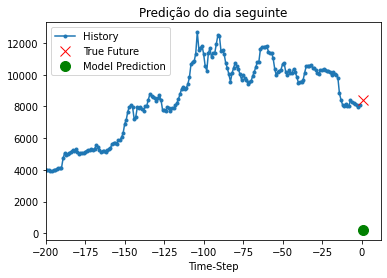

In [492]:

# ToDo: seu código
predict_next_day(modelo_1, testX, testY)

#### Modelo 2:

valor predito do dia 201:  [4393.256]
Valor real do dia 201:  [8431.232]


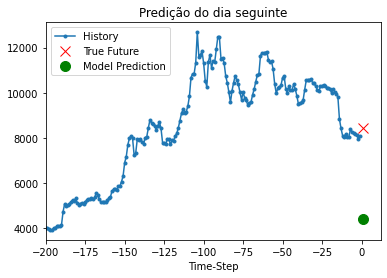

In [493]:

# ToDo: seu código
predict_next_day(modelo_2, testX, testY)

#### Modelo 3:

valor predito do dia 201:  [4319.417]
Valor real do dia 201:  [8431.232]


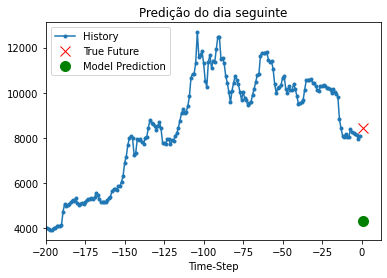

In [494]:

# ToDo: seu código
predict_next_day(modelo_3, testX, testY)

## ToDo: Resultados (15pt)

Coloque os valores dos modelos em uma tabela. Em cada coluna, informe qual a função de custo utilizada, qual otimizador e o erro na partição de teste em RMSE.

```
   -------------------------------------------------------------------
   | Modelo   | Função de Custo |   Otimizador        |      RMSE     |
   --------------------------------------------------------------------
   | Modelo 1 |  Loss(MAE)      | Adam(LR:0.0001)     |   11688.6279  |
   | Modelo 2 |  Loss(MAE)      | RMSprop(LR:0.0001)  |   12608.2158  |
   | Modelo 3 |  Loss(MAE)      | Adam(LR:0.0001)     |   12432.6992  |
   --------------------------------------------------------------------
```
